In [22]:
import numpy as np
from jax import jit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
from glob import glob

In [34]:
file[0]

'./data/20240512/11:47:27_536910/params_95000000_20.48343.npy'

In [77]:
date = '20240512'
#time = '11:47:27_671752'
time = '11:50:31_722685'
path = f'./data/{date}/{time}/'
file = glob(path + 'params_95000000*')
params = np.load(file[0], allow_pickle=True)[()]
config = np.load(path + 'config_dict.npy', allow_pickle=True)[()]

print(file[0][-14:-4])

0_16.95123


In [17]:
date = '20240512'
time = '11:47:27_536910'
timestep = 'params_27450000_20.53504.npy'
path = f'./data/{date}/{time}/'

params = np.load(path + timestep, allow_pickle=True)[()]
config = np.load(path + 'config_dict.npy', allow_pickle=True)[()]

In [59]:
# Use these to calculate the number of trials, how long each trial is, and num conditions
num_trials = config['num_stim']*(config['num_stim']-(1-config['repeats'])) 
task_len = 5 + config['reward']
D = task_len*num_trials # Total number of conditions

# Create inputs and outputs
inputs = np.zeros([config['num_stim'], D])
outputs = np.zeros([config['num_stim']+config['reward'], D])
counter = 0
for target_1 in range(config['num_stim']):
    for target_2 in range(config['num_stim']):
        if target_2 != target_1 or config['repeats']:
            inputs[target_1,counter] = 1
            inputs[target_2,counter + 1] = 1

            outputs[target_1,counter+3] = 1
            outputs[target_2,counter+4] = 1
            if config['reward']:
                outputs[config['num_stim'],counter+5] = 1
            counter += task_len
            
# Now stack a bias on the inputs
inputs = np.vstack([inputs, np.ones([1, inputs.shape[1]])])

In [4]:

def generate_rep(params, inputs):
    g = jnp.zeros([config['N']+1, D])
    g = g.at[-1:,:].set(np.ones([1,g.shape[1]]))
    g = g.at[:-1,::task_len].set(params["I"]@inputs[:,::task_len])
    for t in range(1,task_len):
        g = g.at[:-1,t::task_len].set(params["I"]@inputs[:,t::task_len] + params["W"]@g[:,t-1::task_len])
    return g

# PC extracting function
def get_PCs(vecs, num_eigs = 2):
    vecs = vecs - np.mean(vecs, axis = 1)[:,None]
    covar = vecs@vecs.T
    eigvals, eigvecs = np.linalg.eig(covar)
    
    ordering = np.argsort(eigvals)[::-1]
    #print(f"Propotion of Activity Kept: {np.sum(eigvals[ordering[:2]])/np.sum(eigvals)}")
    return np.real(eigvecs[:,ordering[:num_eigs]])

# Subspace angle calculating function
def calculate_angles(g, inputs, num_eigs = 2):
    inputs_1 = inputs[:3,0::task_len]
    inputs_2 = inputs[:3,1::task_len]
    inputs_both = [inputs_1, inputs_2]
    
    PCs = np.zeros([N, 2, num_eigs])
    for order in range(2):
        diff_vec = []
        for q in range(3):
            indices = np.where(inputs_both[order][q,:] == 1)[0]
            for index in range(len(indices)):
                for index2 in range(index):
                    if index != index2:
                        diff_vec.append(g[:,indices[index]] - g[:,indices[index2]])
        diff_vec = np.stack(diff_vec).T
        PCs[:,order,:] = get_PCs(diff_vec, num_eigs = num_eigs)      

    U, S, V = np.linalg.svd(PCs[:,0,:].T@PCs[:,1,:])
    angles = np.arccos(S)/np.pi*180
    return angles

@jit
def loss_pos(g):
    g_neg = (g[:-1,:] - jnp.abs(g[:-1,:]))/2
    L_pos = -jnp.sum(g_neg)
    return L_pos

@jit
def loss_act(g):
    return jnp.sum(jnp.power(g[:-1,:], 2))

@jit
def loss_weight(W):
    return jnp.sum(jnp.power(W[:,:-1], 2))

@jit
def loss_weight_I(I):
    return jnp.sum(jnp.power(I[:,:-1],2))


@jit
def generate_R(g, outputs):
    mat0 = jnp.matmul(g, g.T)
    mat1 = jnp.matmul(g, outputs.T)
    mat2 = jnp.matmul(jnp.linalg.inv(mat0 + 0.0001*jnp.eye(N+1)), mat1)
    return mat2

@jit
def loss_R(R):
    return jnp.linalg.norm(generate_R(g, targets))**2

@jit
def loss_fit(g, R, outputs):
    preds = R.T@g
    return jnp.linalg.norm(outputs - preds)

@jit
def loss(params, inputs, outputs):
    g = generate_rep(params, inputs)
    R = generate_R(g, outputs)
    
    return mu_fit*jnn.relu(loss_fit(g, R, outputs)-fit_thresh) + mu_G*loss_act(g) + mu_W*(loss_weight(params["W"])) + mu_R*(loss_weight_I(params["I"]) + loss_weight(R)) + mu_pos*loss_pos(g)

In [5]:
params['I'].shape

(50, 4)

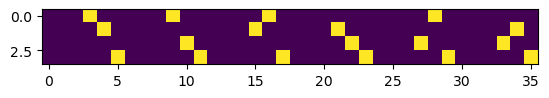

In [60]:
plt.imshow(outputs)

In [79]:
g = generate_rep(params, inputs)

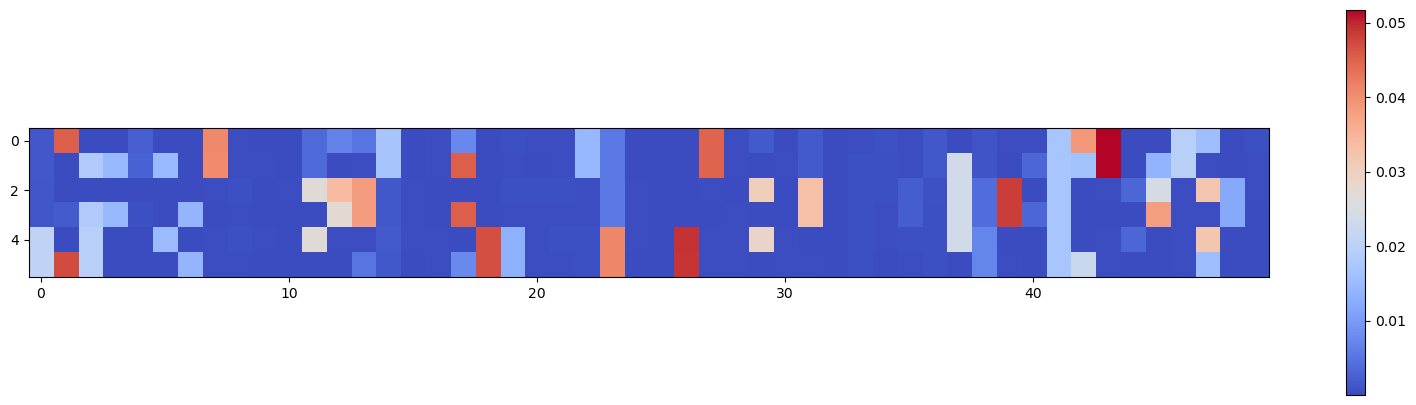

In [80]:
plt.figure(figsize = (20, 5))
plt.imshow(g[:-1,2::task_len].T, cmap='coolwarm')
plt.colorbar()

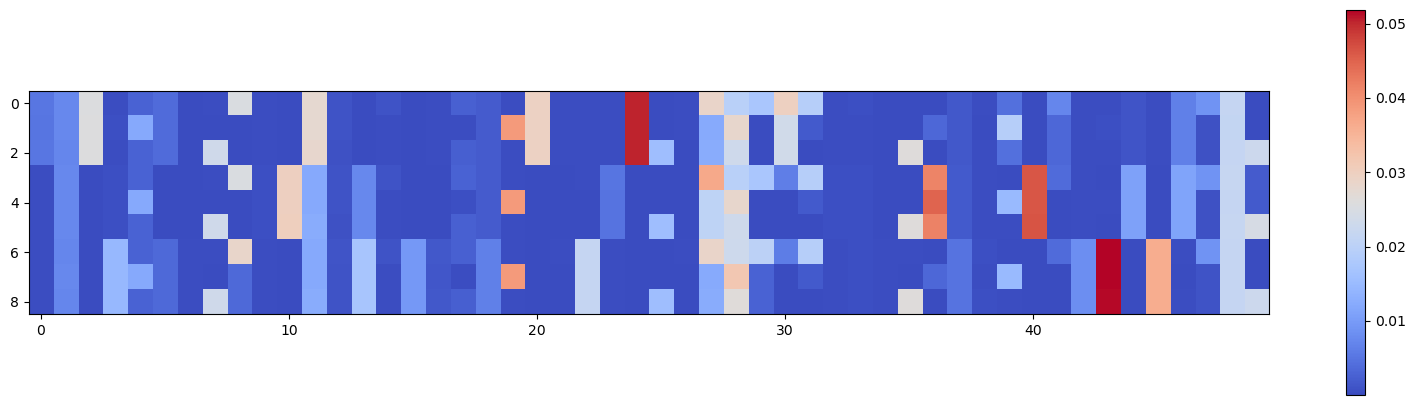

In [55]:
plt.figure(figsize = (20, 5))
plt.imshow(g[:-1,2::task_len].T, cmap='coolwarm')
plt.colorbar()

In [15]:
config['repeats']

1